`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   




# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. 
### Работу выполнила студентка ПМИ3-1 Марахова Екатерина, вариант №13.




В практических примерах ниже показано:   

* как снижать размерность пространства признаков методами главных компонент (PCR), частных наименьшах квадратов (PLS)  
* как строить логистическую регрессию с регуляризацией параметров (методы ридж и лассо) 

Точность всех моделей оценивается методом перекрёстной проверки по 10 блокам.  

*Модели*: множественная линейная регрессия 

*Данные*: `default_of_credit_card_clients` (источник: [репозиторий](https://github.com/aksyuk/MTML/blob/main/Labs/data/default_of_credit_card_clients.csv))

*Объясняющие переменные*: все, кроме Y

*Метод снижения размерности*: регрессия на главные компоненты(PCR)

*Метод регуляризации*: ридж-регрессия


# Ход работы


## Загружаем пакеты

In [312]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [313]:
# константы
#  ядро для генератора случайных чисел
my_seed = 13
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/default_of_credit_card_clients.csv
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [314]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## Загружаем данные

Данные по кредитам 30000 клиентов банков Тайваня (статистика 2005 года). 

`Задача`: спрогнозировать дефолт платежа в следущем месяце по статистике за 6 предыдущих месяцев и по общим сведениям о клиенте. 

`Источник данных`: статья Yeh, I. C., & Lien, C. H. The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480. (Набор данных был загружен из репозитория [UCI](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)).

### Список столбцов файла: 
* `LIMIT_BAL` – размер выданного кредита (новых тайваньских долларов);  
  
  
* `SEX` – пол:  
1 = мужской,   
2 = женский;   

  
* `EDUCATION` – образование:  
1 = аспирантура,   
2 = университет,   
3 = старшая школа,   
4 = другое;  
  
  
* `MARRIAGE` – семейное положение:   
1 = женат/замужем,   
2 = одинок,   
3 = другое;  
  
  
* `AGE` – возраст, лет;  
  
  
* `PAY_0, PAY_2, ..., PAY_6` – статус последних ежемесячных платежей, с сентября (`PAY_0`) по апрель (`PAY_6`) 2005 года:   
\-1 = платёж внесён вовремя,   
1 = платёж внесён с опозданием на 1 месяц;   
2 = с опозданием на 2 месяца,   
и т.д.,   
9 = с опозданием на 9 месяцев и более;  
  
  
* `BILL_AMT1, ..., BILL_AMT6` – размер последних ежемесячных платежей (новых тайваньских долларов), с сентября (`BILL_AMT1`) по апрель (`BILL_AMT6`) 2005 года;  
  
  
* `PAY_AMT1, ..., PAY_AMT6` – размер ежемесячных платежей в предыдущем месяце (новых тайваньских долларов), с сентября (`PAY_AMT1` за август) по апрель (`PAY_AMT6` за март) 2005 года;  
  
  
* `Y` – целевая переменная: дефолт в следующем месяце (1 – да, 0 – нет).


Далее загружаем данные во фрейм,  и выясняем их размерность.  

In [315]:
# загружаем таблицу и превращаем её во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/default_of_credit_card_clients.csv'
DF_all = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


Отложим 15% наблюдений для прогноза.  

In [316]:
# наблюдения для моделирования
DF = DF_all.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [317]:
# первые 5 строк фрейма, 11 первых столбцов
DF.iloc[:, :11].head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
3195,20000,1,3,2,39,0,0,0,0,2,2
15960,300000,2,1,2,30,0,0,0,0,0,0
17713,120000,2,1,2,30,0,0,0,0,0,0
17897,110000,1,1,2,27,0,0,0,0,0,0
23049,200000,2,1,1,41,1,-1,0,-1,2,0


In [318]:
# первые 5 строк фрейма у столбцов 12-17
DF.iloc[:, 11:17].head(5)

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
3195,7824,9000,9867,11929,12091,12245
15960,217329,206703,203164,164371,161331,154515
17713,170263,157881,160796,160168,156165,158850
17897,87487,90120,93661,96185,99667,102978
23049,2217,61328,2877,160944,156864,160066


In [319]:
# первые 5 строк фрейма у столбцов 17-24
DF.iloc[:, 18:24].head(5)

,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
3195,1174,2236,500,500,0,0
15960,20219,7500,6500,7500,6000,0
17713,5700,5815,5500,5522,6000,0
17897,5000,5000,5000,5000,4000,0
23049,2877,160944,0,5900,13000,1


In [320]:
# типы столбцов фрейма
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [321]:
# считаем пропуски в каждом столбце
DF.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

Пропусков не обнаружено.  

# Предварительный анализ данных  

## Описательные статистики  

Считаем доли классов целевой переменной `Y`.  

In [322]:
# метки классов
DF.Y.unique()

array([0, 1])

In [323]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.781
1    0.219
Name: Y, dtype: float64

Все объясняющие переменные набора данных непрерывные. Рассчитаем для них описательные статистики.  

In [324]:
# описательные статистики
DF.iloc[:, :5].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,167848.614902,1.604510,1.854078,1.551137,35.473647
std,129894.926164,0.488965,0.791689,0.521709,9.224644
min,10000.000000,1.000000,0.000000,0.000000,21.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000
max,800000.000000,2.000000,6.000000,3.000000,79.000000


In [325]:
# описательные статистики
DF.iloc[:, 5:11].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,-0.019294,-0.136745,-0.171020,-0.226353,-0.272706,-0.295529
std,1.125633,1.197933,1.193489,1.167079,1.131698,1.151099
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [326]:
# описательные статистики
DF.iloc[:, 11:17].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000
mean,51145.782353,49093.645412,4.689561e+04,43011.959020,40047.777804,38657.944118
std,73030.089201,70556.209422,6.893268e+04,63681.324672,60026.412733,59003.614301
min,-165580.000000,-69777.000000,-6.150600e+04,-170000.000000,-81334.000000,-339603.000000
25%,3578.000000,2956.500000,2.635000e+03,2280.000000,1740.750000,1242.000000
50%,22344.500000,21224.000000,2.003500e+04,19010.000000,18067.000000,17001.500000
75%,67573.250000,64367.000000,6.031300e+04,54429.500000,50065.250000,49162.750000
max,653062.000000,671563.000000,1.664089e+06,706864.000000,587067.000000,699944.000000


In [327]:
# описательные статистики
DF.iloc[:, 17:].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
count,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,5721.081059,5.912399e+03,5195.790706,4851.610588,4847.703137,5248.818863,0.219216
std,16819.669309,2.259416e+04,16745.180224,15980.476266,15559.835697,17901.580110,0.413723
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.360000e+02,390.000000,298.750000,243.750000,108.750000,0.000000
50%,2111.500000,2.010000e+03,1826.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,5015.000000,5.000000e+03,4512.750000,4027.000000,4064.250000,4000.000000,0.000000
max,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000,1.000000


**Выводы по описательным статистикам**: некоторые минимумы значений принимают отрицательные значения, а стандартные отклонения имеют очень большие значения и достаточно большой разброс, что говорит о неоднородности данных. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Визуализация разброса переменных внутри классов  
Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

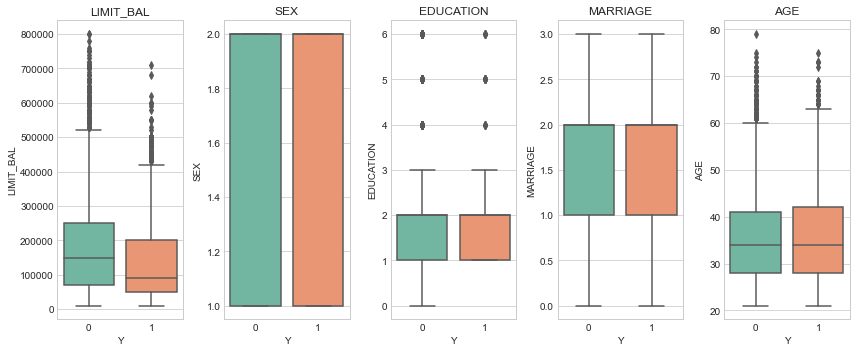

In [328]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

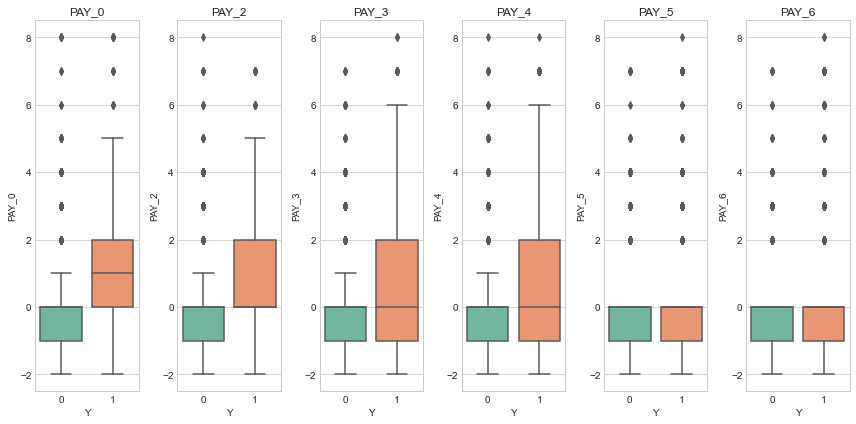

In [329]:
# создаём полотно и делим его на пять частей
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(1, 6)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
ax6 = plt.subplot(gs[0, 5])

axs = [ax1, ax2, ax3, ax4, ax5, ax6]

cols_loop = list(DF.columns[5:11].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

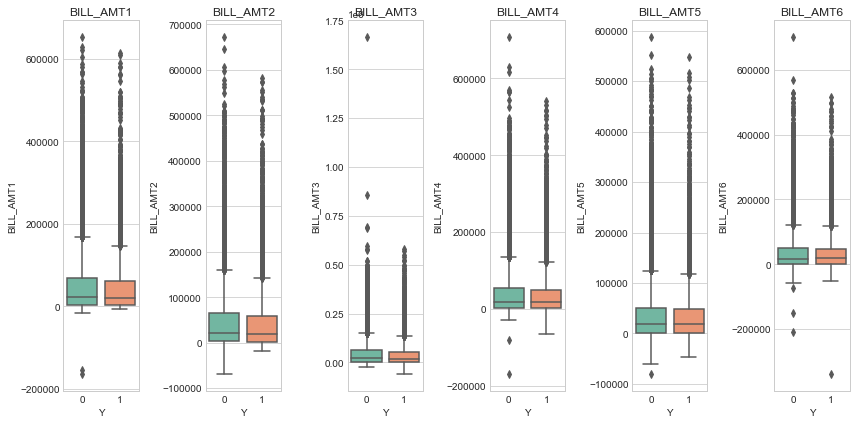

In [330]:
# создаём полотно и делим его на пять частей
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(1, 6)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
ax6 = plt.subplot(gs[0, 5])

axs = [ax1, ax2, ax3, ax4, ax5, ax6]

cols_loop = list(DF.columns[11:17].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

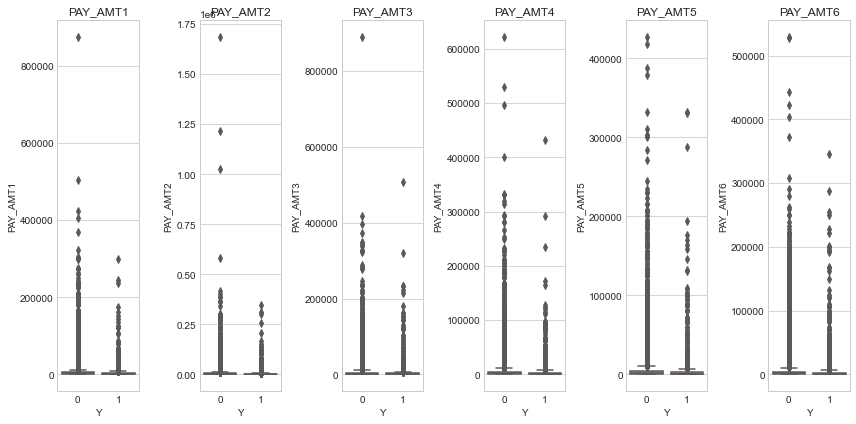

In [331]:
# создаём полотно и делим его на пять частей
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(1, 6)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])
ax6 = plt.subplot(gs[0, 5])

axs = [ax1, ax2, ax3, ax4, ax5, ax6]

cols_loop = list(DF.columns[17:23].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

Только на одном графике можно наблюдать хорошее разделение по классам - `PAY_0` и `PAY_2`, остальные практически не различаются. Это говорит о том, классы по зависимой переменной `Y` плохо разделяются по всем объясняющим переменным.  

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

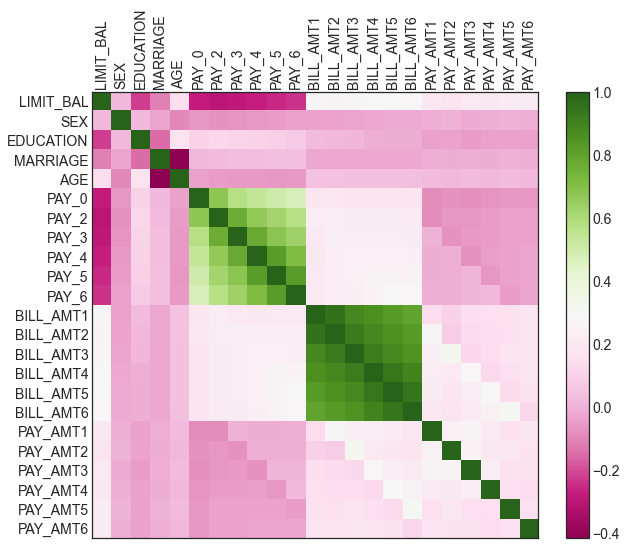

In [332]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

#### Вывод по тепловой карте

Более тесные положительные связи прослеживаются между переменными `BILL_AMT1, BILL_AMT1, ..., BILL_AMT6`, чуть менее тесные положительные - `PAY_0, PAY_1, ..., PAY_6`. 

Также видно и тесные отрицательные связи между `MARRIAGE` и `AGE` и менее тесные между `LIMIT_BAL` и `PAY_0, PAY_1, ..., PAY_6`.

In [333]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
63,MARRIAGE,AGE,-0.415966,0.0
5,LIMIT_BAL,PAY_2,-0.299018,0.0
6,LIMIT_BAL,PAY_3,-0.288579,0.0
4,LIMIT_BAL,PAY_0,-0.274504,0.0
7,LIMIT_BAL,PAY_4,-0.268215,0.0
...,...,...,...,...
208,BILL_AMT3,BILL_AMT4,0.920791,0.0
198,BILL_AMT2,BILL_AMT3,0.925152,0.0
217,BILL_AMT4,BILL_AMT5,0.938409,0.0
225,BILL_AMT5,BILL_AMT6,0.944524,0.0


Как и было сказано выше, самая сильная обратная связь между `MARRIAGE` и `AGE`, а прямая между `BILL_AMT1` и `BILL_AMT2`.

# Частный метод наименьших квадратов (PLS)

Проведем частный метод наименьших квадратов (PLS). Для этого предварительно стандартизируем переменные.  

In [334]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :23].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1: среднее = 0.0   Станд. отклонение = 1.0
Столбец 2: среднее = -0.0   Станд. отклонение = 1.0
Столбец 3: среднее = -0.0   Станд. отклонение = 1.0
Столбец 4: среднее = -0.0   Станд. отклонение = 1.0
Столбец 5: среднее = -0.0   Станд. отклонение = 1.0
Столбец 6: среднее = 0.0   Станд. отклонение = 1.0
Столбец 7: среднее = -0.0   Станд. отклонение = 1.0
Столбец 8: среднее = 0.0   Станд. отклонение = 1.0
Столбец 9: среднее = -0.0   Станд. отклонение = 1.0
Столбец 10: среднее = 0.0   Станд. отклонение = 1.0
Столбец 11: среднее = 0.0   Станд. отклонение = 1.0
Столбец 12: среднее = -0.0   Станд. отклонение = 1.0
Столбец 13: среднее = 0.0   Станд. отклонение = 1.0
Столбец 14: среднее = 0.0   Станд. отклонение = 1.0
Столбец 15: среднее = -0.0   Станд. отклонение = 1.0
Столбец 16: среднее = 0.0   Станд. отклонение = 1.0
Столбец 17: среднее = 0.0   Станд. отклонение = 1.0
Столбец 18: среднее = 0.0   Станд. отклонение = 1.0
Столбец 19: с

#### Посмотрим, как работает метод на всех наблюдениях обучающего набора.  

In [335]:
# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=23)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(DF.Y.astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)

# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis=0) / np.sum(np.var(X_train_std, axis=0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.182 0.138 0.062 0.045 0.025 0.029 0.018 0.022 0.01  0.023 0.015 0.009
 0.02  0.007 0.019 0.007 0.018 0.008 0.012 0.03  0.014 0.025 0.001] 
Общая сумма долей: 0.738


Из-за того, что при вычислении компонент метдом PLS мы учитываем корреляцию с $Y$, компоненты, во-первых, не ортогональны, а во-вторых сумма объяснённых долей дисперсии уже не равняется 1.  

In [336]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=2)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.653317,0.346683
1,0.898155,0.101845
2,0.849661,0.150339
3,0.791355,0.208645
4,0.855911,0.144089
...,...,...
25495,0.466756,0.533244
25496,0.416469,0.583531
25497,0.713096,0.286904
25498,0.982243,0.017757


In [337]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred : 
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# Y_train_hat
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(0, 24683), (1, 817)])

Рисуем классы на графике в координатах 2 главных компонент по PLS.  

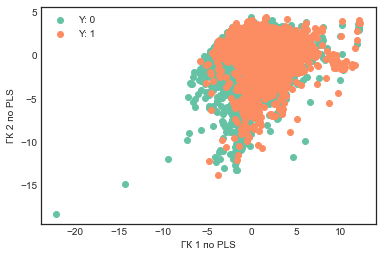

In [338]:
# график классов в пространстве ГК
plt.scatter(X_train_pls[DF['Y'] == 0][:, 0], 
            X_train_pls[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pls[DF['Y'] == 1][:, 0], 
            X_train_pls[DF['Y'] == 1][:, 1], label='Y: 1')

plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

Видно, что в координатах двух компонент, рассчитанных методом частных наименьших квадратов, классы **не** оказываются четко разделимыми.  
Теперь оценим точность модели с перекрёстной проверкой.  

In [339]:
# функция разбиения на блоки для перекрёстной проверки
#  для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
#  функция cross_val_score не сработает, т.к. у нас мультиклассовая
#  классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=2)
# для записи Acc по блокам
acc_blocks = list()
# цикл по блокам
for train_index, test_index in kf_10.split(X_train_std, DF.Y.values) : 
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]

    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]

    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred : 
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)

score = list()
score.append(np.around(np.mean(acc_blocks), 3))
score_models = list()
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')



Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 0.8


# Методы сжатия  

## Ридж-регрессия  

Функция `LogisticRegression()` умеет работать с мультиклассовой классификацией, используя при оценке параметров подход **один класс против остальных**. Построим ридж на наших данных.  

In [340]:
logit_ridge.intercept_

array([-1.4765329])

In [304]:
# функция для построения модели
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear')
# оцениваем параметры
logit_ridge.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))

Константы моделей для классов:
 [-1.477] 
Коэффициенты моделей для классов:
 [[-0.103 -0.056 -0.078 -0.072  0.077  0.64   0.112  0.077  0.028  0.041
   0.006 -0.42   0.222  0.08  -0.036  0.024  0.032 -0.217 -0.21  -0.043
  -0.072 -0.05  -0.032]]


Подбираем гиперпараметр регуляризации $\lambda$ с помощью перекрёстной проверки. В функции 
`LogisticRegression()` есть аргумент $C$ – это инверсия гиперпараметра $\lambda$.   

In [302]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2, 
                                penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
ridge_cv.C_

array([0.35938137])

In [303]:
# сохраняем и выводим Acc для модели
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 0.812


Изобразим изменение коэффициентов ридж-регрессии на графике и сделаем отсечку на уровне оптимального параметра $C$.  

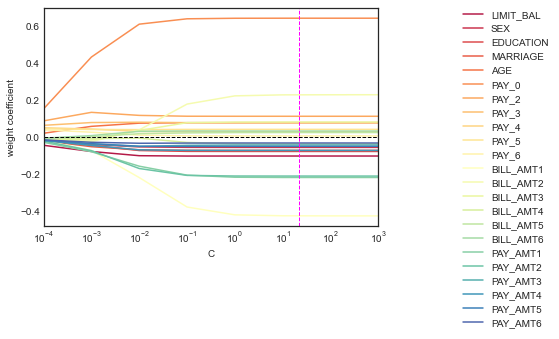

In [299]:
# график динамики коэффициентов в ридж-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)

IndexError: index 1 is out of bounds for axis 0 with size 1

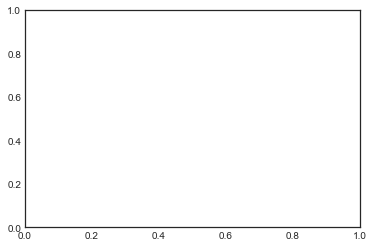

In [295]:
# график динамики коэффициентов в ридж-регрессии    
#  модель для класса 1
plot_coeffs_traces(X_train_std, Y_train, 1, 'l2', ridge_cv.C_, DF.columns)

# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [300]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PLS,0.796
1,logit_ridge,0.812
2,logit_ridge,0.812


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается ридж-регрессия. Сделаем прогноз на отложенные наблюдения.   

In [301]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :23].values)
Y_pred = DF_predict.Y
Y_hat = logit_ridge.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      3454
           1       0.71      0.22      0.34      1046

    accuracy                           0.80      4500
   macro avg       0.76      0.60      0.61      4500
weighted avg       0.78      0.80      0.76      4500



Таким образом, методом логистической регрессии со сжатием коэффициенты с L2-регуляризацией мы получили модель классификации для двух видов дефолта.

# Источники 

1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. Репозиторий с кодом к книге *Рашка С.* Python и машинное обучение / github.com. URL: <https://github.com/rasbt/python-machine-learning-book-3rd-edition>  
1. *Xueting Bai*, *Lingbo Wang*, *Hanning Li* Identification of red wine categories based on physicochemical properties / 2019 5th International Conference on Education Technology, Management and Humanities Science (ETMHS 2019). URL: <https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf>  

